Plot relative abundances for lung transplant patients

Input files: shannon_dv.txt (alpha diversity), otu.txt (OTU table), blastn_alignment.xml (Blastn alignment output), taxonomy.tsv (OTU-to-taxa conversion from Qiime2)


In [22]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 10]
import warnings
warnings.filterwarnings('ignore')

In [23]:
def setCondition_alpha(row):
    """
    Make a column with 'healthy', 'CF' or 'LT'. Takes row in DF as input and returns value depending on the row 
    value. 
    
    According to instructions; CF with a LT is classified as healthy.  
    """
    
    if row['Cystic_fibrosis'] == 'yes':
        
        if row['Lung_Transplant'] == 'yes':
            
            return 'Healthy'
        
        else:
            
            return 'Cystic Fibrosis'
        
    return 'Healthy'

In [24]:
def setLT_alpha(row):
    """
    Make a column with 'No', 'Yes' which is an snswer to the question 'Did the patient had a lung transplant?'.
    Takes row in DF as input and returns value depending on the row value. 
    """
    
    if row['Lung_Transplant'] == 'yes':
            
        return 'Lung Transplant'

    else:    
        return 'Other'

In [25]:
def group_by_heading( some_source ):

   buffer= []
   for line in some_source:

      # Fasta file header, i.e. '>'
      if line.startswith( ">" ):
         if buffer: yield buffer
         buffer= [ line ]
      else:
         buffer.append( line )
   yield buffer

In [26]:
def connectFeatureIDtoTaxa(row, taxa_dict, taxa_pick):
    """
    Function which takes a feature ID as input, iterate through a dictionary with feature ID as keys
    and taxas as value. 
    Example on a key/value pair: 
    '12bf2f325bfc152cf0e6856d8717f82b': 
    ['k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae', 
    0.9980158267006052]
    
    Returns the correspondning taxa.
    """
    for key, value in taxa_dict.items():
        
        if key == row['#OTU ID']:
            
            return value[taxa_pick]

In [27]:
from collections import Counter 
from itertools import takewhile

def get_items_upto_count(dct, n):
    """
    Takes a Counter dict as input and returns the all of the keys with the higest count.
    """
    data = dct.most_common()
    val = data[n-1][1] #get the value of n-1th item
    #Now collect all items whose value is greater than or equal to `val`.
    return list(takewhile(lambda x: x[1] >= val, data))    

def most_frequent(List, store_genus): 
    occurence_count = Counter(List) 

    ocd = dict(occurence_count)
    
    # STore all ge+sp which have the highest count
    spge_highest_count = get_items_upto_count(occurence_count, 1) # returns [('A', 3), ('C', 3)]
    
    if len(spge_highest_count) == 1: # One species is the most frequent
        return spge_highest_count[0][0]
        
    else: # All species are equally frequent
        
        # Multiple species
        sp_list = list()
        for sp in spge_highest_count:
                
            # Append with genus
            sp_list.append(sp[0].split(' ')[0])
            
        if len(list(set(sp_list))) == 1:
            
            genus = list(set(sp_list))[0]
            return genus + ' ' + str('spp.')
        
        else: # Multiple genus
            ge_list = list()
            for item in spge_highest_count:
                ge_list.append(item[0].split(' ')[0]) # Add genuses to list
                
                if item[0].split(' ')[0] == store_genus:
                    return item[0] + ' ' + str('spp.')
                    
            # No match with Qiime2 genus assignment
                    
            # Find most abundant genus in ge_list
            ge_count = Counter(ge_list)
                    
            # Store genus with the highest count
            ge_highest_count = get_items_upto_count(ge_count, 1) # returns [('A', 3), ('C', 3)]
        
            return ge_highest_count[0][0] + ' ' + str('spp.')
                     

def mostIdenticalGenus(row, dict_input):
    """
    Row and OTUid-BLASTalignments dictionary as input. Depending on what Qiime2 assigned as taxa, I return the 
    most matching taxa from the BLAST aligments. If nothing (genus and/or specie) is identical in BLAST and Qiime2
    I return the BLAST assignment which got the most occuring assignments. 
    
    """

    # THere are some alignments with identical filter values but where one is associated with human, CF 
    # and/or lungs (manually curated) and the other with something else (plants for example)
    # Key is BLAST alignment name, value is manually curated. 
    manually_curated_taxa_dict = {'Stenotrophomonas pavanii':'Stenotrophomonas maltophilia', 
                  'Ralstonia solanacearum':'Ralstonia mannitolilytica'}
    
    # If OTU in dict keys
    if row['#OTU ID'] in dict_input:
        
        store_genus_list = list()
        
        # Go through the value lists for that key
        for val in dict_input[row['#OTU ID']]:
            
            # If the assigned BLAST genus+specie match the Qiime2 Genus+Specie, pick that BLAST assignment
            if val[1].split(' ')[0] == row['Genus'] and val[1].split(' ')[1] == row['Species']:
                
                # Check against the manually curated taxa
                if val[1] in manually_curated_taxa_dict:
                    
                    return manually_curated_taxa_dict[val[1]]
                
                else:
                    return val[1]
                
            # If the assigned BLAST genus match the Qiime2 Genus, store that BLAST assignment
            elif val[1].split(' ')[0] == row['Genus']:
                store_genus_list.append('Genus')
            
        if list(set(store_genus_list)) != 0:
            
            store_genus = str(list(set(store_genus_list)))
            
        else:
        
            store_genus = 'No Genus'
                
        # Create DF from the key values, example value in dict looks like this:
        #[[' Moraxella nonliquefaciens strain 4663/62 16S ribosomal RNA, partial sequence','Moraxella nonliquefaciens', 5.05092e-87, 99.429], 
        #[' Moraxella nonliquefaciens strain CCUG 348 16S ribosomal RNA, partial sequence', 'Moraxella nonliquefaciens', 5.05092e-87, 99.429], 
        #[' Moraxella catarrhalis strain Ne 11 16S ribosomal RNA, partial sequence', 'Moraxella catarrhalis', 5.05092e-87, 99.429]]
        value_df = pd.DataFrame(dict_input[row['#OTU ID']], columns = ['Full name', 'Short name', 'e-value', 'ident.%'])
        
        kk = value_df.groupby('e-value')
        
        # Select the top group (with lowest e-value) and make 'short list' column to list
        shoart_name_list = kk.get_group((list(kk.groups)[0]))['Short name'].tolist()
        
        # Check for the most abundant short name in list   
        most_freq_short_name = most_frequent(shoart_name_list, store_genus)
        
        # Return the most abundant BLAST genus+specie
        # Check against manually curated dict
        if most_freq_short_name in manually_curated_taxa_dict:
            
            return manually_curated_taxa_dict[most_freq_short_name]
        
        else:
            return most_freq_short_name
                
                
    # If OTU ID can't be found in BLAST dict, take what has been assigned in Qiime2
    elif (row['Genus'] != 'Undetermined') & (row['Species'] != 'Undetermined'): # Genus + species are available
        
        return str(row['Genus']) + ' ' + str(row['Species'])
    
    elif (row['Genus'] != 'Undetermined') & (row['Species'] == 'Undetermined'): # Genus is available
        
        return str(row['Genus']) + ' ' + str('spp.')

    

In [28]:
def colormap_to_66taxas(ll):
    """
    Colormap for max 66 taxas.
    Take a list with taxas as input, which need to have a color assigned to it. 
    """
    import matplotlib.colors as mcolors
    
    taxa_color_dict = {}
    
    # Keep only unique taxas
    collect_taxa_list_unique = list(set(ll))
    collect_taxa_list_unique.sort()

    # sample the colormaps that you want to use. Use 6 from each so we get 66 colors in total
    corolmaps_list = ['cool', 'winter', 'Greens', 'Oranges', 'pink', 'spring', 'Blues', 'Reds', 'Purples', 'copper', 'Greys']
    seq_colormaps = list()
    
    #Load all the colormaps
    for color in corolmaps_list:
        load_color = plt.cm.get_cmap(color)
        seq_colormaps.append(load_color(np.linspace(0.1, 0.9, 6)))
    
    # combine them and build a new colormap
    cs = np.vstack(tuple(seq_colormaps))
    
    mymap = mcolors.ListedColormap(cs, name='my_colormap') 
    
    # To get special colors for other and undetermined
    for i, member in enumerate(collect_taxa_list_unique):
        if member == 'Other':

            taxa_color_dict[member] = 'silver'

        elif member == 'Undetermined.Undetermined.Undetermined.Undetermined.Undetermined':

            taxa_color_dict[member] = 'k'
            
        else:
            taxa_color_dict[member] = mymap(i)
            
    if not 'Other' in collect_taxa_list_unique:
        taxa_color_dict['Other'] = 'silver'
    
    if not 'Undetermined.Undetermined.Undetermined.Undetermined.Undetermined' in collect_taxa_list_unique:
        taxa_color_dict['Undetermined.Undetermined.Undetermined.Undetermined.Undetermined'] = 'k'
        
    return taxa_color_dict

In [29]:
# Import df with Shannon diveristy

shannon_meta = pd.read_csv('shannon_dv.txt', 
                     sep = '\t')

In [30]:
# Remove samID 'dup05-013-1B' bc it is a duplicated samID
print(shannon_meta.shape)

shannon_meta = shannon_meta[shannon_meta.PatientID != 'dup05-013-1']

print(shannon_meta.shape)

(827, 66)
(825, 66)


In [32]:
# Make a string out of the nans
shannon_meta['Lung_Transplant'].fillna('NA', inplace = True)
shannon_meta['Cystic_fibrosis'].fillna('NA', inplace = True)
shannon_meta['Swab_site'].fillna('NA', inplace = True)
shannon_meta['Swab_occasion'].fillna('NA', inplace = True)
shannon_meta['Total Bile Acid BAL'].fillna('NA', inplace = True)
shannon_meta['Total Bile Acid GF'].fillna('NA', inplace = True)
shannon_meta[['GES_combo']] = shannon_meta[['GES_combo']].astype(str)

shannon_meta['Condition'] = shannon_meta.apply (lambda row: setCondition_alpha(row), axis = 1)
shannon_meta['LT_plot'] = shannon_meta.apply (lambda row: setLT_alpha(row), axis = 1)

shannon_meta_initial_tmp = shannon_meta[((shannon_meta['Swab_occasion'] == 'initial') | (shannon_meta['Swab_occasion'] == 'NA') | (shannon_meta['Swab_occasion'] == 'PPI_final'))
                                    & ((shannon_meta['Condition'] != 'Cystic fibrosis'))]

shannon_meta_initial = shannon_meta_initial_tmp[((shannon_meta_initial_tmp['GES_combo'] != 'nan') | 
                                            (shannon_meta_initial_tmp['Total Bile Acid BAL'] != 'NA') | 
                                            (shannon_meta_initial_tmp['Total Bile Acid GF'] != 'NA'))]



In [33]:
# Merge excel with certain columns in  shannon_meta_initial

merge = pd.merge(shannon_meta_initial[['Shannon diversity index (H)','PatientID','LT_plot', 'GES_combo', 'Swab_site', 'Total Bile Acid GF', 'SamID', 'Cystic_fibrosis']],
                excel[['ID', 'PPI y/n', 'Abx y/n', 'GES Results (0 = normal, 1 = abnormal)', 'Transplant y/n']],
                 left_on='PatientID', right_on='ID', how='left')

merge['PPI y/n'].fillna('NA', inplace = True)
merge['Abx y/n'].fillna('NA', inplace = True)

merge = merge[merge['PPI y/n'] != 'NA']

merge['PPI y/n'] = merge['PPI y/n'].replace({1:'on', 0:'off'})
merge['Abx y/n'] = merge['Abx y/n'].replace({1:'yes', 0:'no'})

print(merge.shape)
print(merge.groupby(['Swab_site', 'LT_plot']).count()['PatientID'])


(264, 13)
Swab_site  LT_plot        
lung       Lung Transplant     5
           Other              54
rectal     Other               1
stomach    Lung Transplant    18
           Other              69
stool      Lung Transplant     2
           Other              13
throat     Lung Transplant    16
           Other              86
Name: PatientID, dtype: int64


In [34]:
## LUNG
lung_LT = merge[(merge['LT_plot'] == 'Lung Transplant') &
                              (merge['Swab_site'] == 'lung')]

## STOMACH
stomach_LT = merge[(merge['LT_plot'] == 'Lung Transplant') &
                              (merge['Swab_site'] == 'stomach')]

## THROAT
throat_LT = merge[(merge['LT_plot'] == 'Lung Transplant') &
                              (merge['Swab_site'] == 'throat')]

LT_random_groups = [lung_LT, stomach_LT, throat_LT]

for gg in LT_random_groups:
    print(gg.shape)

(5, 13)
(18, 13)
(16, 13)


In [35]:
# What are the samIDs in the different groups?
LT_random_groups_samID = []

for groups in LT_random_groups:
    
    samID = groups['SamID'].tolist()
    
    LT_random_groups_samID.append(samID)


In [36]:
# Load the normalized OTU table

OTUtable = pd.read_csv('otu.txt', 
                      sep = '\t', index_col = 0)

In [37]:
# Normalization within each sample
#-------------------------------------
otu_table_norm = OTUtable.copy()


# Calculate sum of each column
otu_col_sum = list()

for item in OTUtable.columns:
    total = OTUtable[item].sum()
    
    otu_col_sum.append(total)

# Divide each row in otu_table with the sum of each column to get the percentage
otu_table_norm = otu_table_norm.div(otu_col_sum, axis=1)

In [38]:
# Get the columns from OTUtable within each group 

LT_random_groups_OTUs = []

for group_list in LT_random_groups_samID:
    
    OTUdf = otu_table_norm[group_list]
    
    LT_random_groups_OTUs.append(OTUdf)

In [39]:
# Load the OTU ID-to-taxa conversion table

taxa_import = pd.read_csv('taxonomy.tsv',
                         sep = '\t')
print(taxa_import.head())

taxa_dict = taxa_import.set_index('Feature ID').T.to_dict('list')

                         Feature ID  \
0  0001d123420b59585627edf5a1292ae8   
1  0004ec6a75f43f63758f414c90dabd77   
2  000c3b583371be35cc4187f81dfbb602   
3  000db46fcff4701589d112bc2a6044de   
4  00186d4a03643fc5458d8a2be2430598   

                                               Taxon  Confidence  
0  k__Bacteria; p__Proteobacteria; c__Alphaproteo...    0.998325  
1  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...    0.936442  
2  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...    0.995499  
3  k__Bacteria; p__Firmicutes; c__Clostridia; o__...    0.797533  
4  k__Bacteria; p__Firmicutes; c__Clostridia; o__...    0.921369  


In [40]:
# I want to replace the feature ID with the taxa found in taxa_table

taxa_pick = 0

taxas = ['Kingdom','Phylum','Class','Order','Family','Genus','Species']

# Reset index to get #OTU ID as a column
for group in LT_random_groups_OTUs:
    
    group.reset_index(inplace = True)

    # Add taxa to melted index/OTU ID table

    group['#Taxa'] = group.apply(connectFeatureIDtoTaxa, args=(taxa_dict, taxa_pick), axis = 1)

In [41]:
for group in LT_random_groups_OTUs:
    # To remove the '[' and ']' some taxa names have in them
    group['#Taxa'].replace('\[','', regex=True, inplace=True)
    group['#Taxa'].replace('\]','', regex=True, inplace=True)

In [42]:
LT_random_groups_OTUs_expanded = []

for group in LT_random_groups_OTUs:
    
    # Split column '#Taxa' into separate taxas
    OTUmetamerge_expanded = group.join(group['#Taxa'].str.split(';', expand=True).add_prefix('Taxon').fillna(np.nan))

    # Set column names
    OTUmetamerge_expanded = OTUmetamerge_expanded.rename(columns = {'Taxon0':'Kingdom', 
                                                               'Taxon1':'Phylum',
                                                               'Taxon2':'Class',
                                                               'Taxon3':'Order',
                                                               'Taxon4':'Family',
                                                               'Taxon5':'Genus',
                                                               'Taxon6':'Species'})

    # Remove the 'D_x__' pattern from the taxa columns
    OTUmetamerge_expanded['Kingdom'] = OTUmetamerge_expanded['Kingdom'].str[3:]
    OTUmetamerge_expanded['Phylum'] = OTUmetamerge_expanded['Phylum'].str[4:]
    OTUmetamerge_expanded['Class'] = OTUmetamerge_expanded['Class'].str[4:]
    OTUmetamerge_expanded['Order'] = OTUmetamerge_expanded['Order'].str[4:]
    OTUmetamerge_expanded['Family'] = OTUmetamerge_expanded['Family'].str[4:]
    OTUmetamerge_expanded['Genus'] = OTUmetamerge_expanded['Genus'].str[4:]
    OTUmetamerge_expanded['Species'] = OTUmetamerge_expanded['Species'].str[4:]
    
    # Fill blanks with NaN
    OTUmetamerge_expanded.replace(r'^\s*$', np.nan, regex=True, inplace = True)
    
    # Replace NaN to 'Undetermined'
    OTUmetamerge_expanded.fillna('Undetermined', inplace = True)
    
    # Add df in list with the other groups
    LT_random_groups_OTUs_expanded.append(OTUmetamerge_expanded)

Fastq files run in BLASTn 16S database and collected the top 10 query matches in a XML single file.

Output is a XML file with all the alignments.

In [43]:
from Bio.Blast import NCBIXML

# Used the 16S database in NCBI to do this search

xml_path = 'blastn_alignment.xml'

E_VALUE_THRESH = 0.01
 
# To store results per query in dict with OTU ID as key and alignment info as values in lists
store_dicttBIG = {}

# Open and parse XML file
for blast_record in NCBIXML.parse(open(xml_path)):
    
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            if hsp.expect < E_VALUE_THRESH:
                
                # Get the % identity
                pindent = float("%0.3f" % (100 * float(hsp.identities) / float(hsp.align_length)))
                
                # Genus + species name
                ge_sp_name = ' '.join([alignment.title.split('|')[4].split(' ')[1], alignment.title.split('|')[4].split(' ')[2]])
            
                # Sequence title
                seq_title = alignment.title.split('|')[4]
            
                # e-value
                e_val = hsp.expect
                
                # Do some filtering on the % identity and e value
                ident_threshold = float(99)
                e_val_threshold = float(1e-50)
                
                if pindent > ident_threshold and e_val < e_val_threshold:
                    
                    align_info = [seq_title, ge_sp_name, e_val, pindent]
            
                    # Check if key exists in dict and append new value if it exits
                    if blast_record.query in store_dicttBIG:
                        store_dicttBIG[blast_record.query].append(align_info)
                
                    # Create new key in dict if not already there
                    else:
                        store_dicttBIG[blast_record.query] = [align_info]

In [44]:
# Return the BLAST genus + specie values to the mono_mulit_groups_expanded's items
# Only for the rows where taxa wasn't assigned by Qiime2 = these are the OTU keys stored in OTU_BLAST_dict

for groups in LT_random_groups_OTUs_expanded:
    
    groups['BLAST Genus.Specie'] = groups.apply(lambda row: mostIdenticalGenus(row, store_dicttBIG), axis = 1)
    
print(LT_random_groups_OTUs_expanded[0].head())

                            #OTU ID  05-003-7B  05-004-1B  05-178-4B  \
0  0001d123420b59585627edf5a1292ae8        0.0        0.0        0.0   
1  0004ec6a75f43f63758f414c90dabd77        0.0        0.0        0.0   
2  000c3b583371be35cc4187f81dfbb602        0.0        0.0        0.0   
3  000db46fcff4701589d112bc2a6044de        0.0        0.0        0.0   
4  00186d4a03643fc5458d8a2be2430598        0.0        0.0        0.0   

   K05-006-7B  K05-387-1B                                              #Taxa  \
0         0.0         0.0  k__Bacteria; p__Proteobacteria; c__Alphaproteo...   
1         0.0         0.0  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   
2         0.0         0.0  k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...   
3         0.0         0.0  k__Bacteria; p__Firmicutes; c__Clostridia; o__...   
4         0.0         0.0  k__Bacteria; p__Firmicutes; c__Clostridia; o__...   

    Kingdom          Phylum                Class          Order  \
0  Bacteria  Proteo

In [45]:
for groups in LT_random_groups_OTUs_expanded:
    
    # Split BLAST Genus.Specie column into two, one with Genus name and one with specie name
    groups[['BLAST Genus','BLAST Specie']] = groups['BLAST Genus.Specie'].str.split(" ", n= 1, expand=True)
    
    # Fill None cells with 'Undetermined'
    groups[['BLAST Genus','BLAST Specie']] = groups[['BLAST Genus','BLAST Specie']].fillna('Undetermined')

    # Join all Taxa Level Names with dot
    groups['Full Taxa'] = groups['Phylum'] + '.' + groups['Class'] + '.' + groups['Order'] + '.' + groups['Family'] + '.' + groups['BLAST Genus'] #+ '.' + groups['BLAST Specie']
    
    # If a 'Full Taxa' == Undetermined Undetermined, I wanna change that to just one 'Undetermined'
    groups.loc[groups['Full Taxa'] == 'Undetermined Undetermined', 'Full Taxa'] = 'Undetermined'
    
LT_random_groups_OTUs_expanded[2].head()


,#OTU ID,05-171-9T,05-176-4T,05-178-4T,05-206-2-T,BLD-065-3T,K05-188-9T,K05-199-3T,K05-220-1T,K05-226-1T,...,Phylum,Class,Order,Family,Genus,Species,BLAST Genus.Specie,BLAST Genus,BLAST Specie,Full Taxa
0,0001d123420b59585627edf5a1292ae8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Proteobacteria,Alphaproteobacteria,Rhizobiales,Bradyrhizobiaceae,Balneimonas,Undetermined,Microvirga aerophila,Microvirga,aerophila,Proteobacteria.Alphaproteobacteria.Rhizobiales...
1,0004ec6a75f43f63758f414c90dabd77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Undetermined,Prevotella buccalis,Prevotella,buccalis,Bacteroidetes.Bacteroidia.Bacteroidales.Prevot...
2,000c3b583371be35cc4187f81dfbb602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Undetermined,Prevotella spp.,Prevotella,spp.,Bacteroidetes.Bacteroidia.Bacteroidales.Prevot...
3,000db46fcff4701589d112bc2a6044de,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Firmicutes,Clostridia,Clostridiales,Undetermined,Undetermined,Undetermined,None,Undetermined,Undetermined,Firmicutes.Clostridia.Clostridiales.Undetermin...
4,00186d4a03643fc5458d8a2be2430598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Undetermined,Undetermined,None,Undetermined,Undetermined,Firmicutes.Clostridia.Clostridiales.Lachnospir...


In [46]:
samID_list_str = ['Lung Transplant, lung', 
                  'Lung Transplant, stomach', 
                  'Lung Transplant, throat']

taxa_BLAST_bar_plotting_ALL = []

percentage = 0.01

for i in range(len(LT_random_groups_samID)):
    
    # To remove the '[' and ']' some taxa names have in them
    LT_random_groups_OTUs_expanded[i]['Full Taxa'].replace('\[','', regex=True, inplace=True)
    LT_random_groups_OTUs_expanded[i]['Full Taxa'].replace('\]','', regex=True, inplace=True)
    
    # Unwanted coloumns making bar plots
    tmp = LT_random_groups_OTUs_expanded[i].drop(['#OTU ID', 
                       '#Taxa', 
                       'Kingdom', 
                       'Phylum', 
                       'Class', 
                       'Order', 
                       'Family', 
                       'Genus', 
                       'Species', 
                       'BLAST Genus.Specie', 
                       'BLAST Genus', 
                       'BLAST Specie'], axis = 1)
    
    tmp = tmp.set_index('Full Taxa')
    
    # Transpose dataframe (sampleID as rows and TAXAs as columns)
    tmp_transpose = tmp.T
    tmp_transpose.reset_index(inplace=True)
    
    # Make OTU transposed table tidy! :)
    tmp_table_melt = pd.melt(tmp_transpose, id_vars=['index'])

    # Remove rows with value > 0
    tmp_table_melt = tmp_table_melt[tmp_table_melt.value != 0]
    
    # Groupby index and Taxa and sum the percentages of each group
    taxa_val_per = tmp_table_melt.groupby(['index', 'Full Taxa'])['value'].agg('sum').reset_index()
    
    # change name of the 'value' column to know that it is percentage now
    taxa_val_per.columns = ['index', 'Full Taxa', 'value percentage'] 
    
    # Only keep values over a certain value percentage
    taxa_val_per2 = taxa_val_per[taxa_val_per['value percentage'] > percentage]
    
    taxa_val_per2.reset_index(inplace=True, drop=True)
    
    ############# This is to get every taxon < percentage specified above to be grouped together and presented as
    ############# an 'Other' taxon. To get 100% for all samples. 
    # Get the index in a list
    taxa_val_per2_index_list = list(set(taxa_val_per2['index'].tolist()))
    taxa_val_per2_index_list.sort()
    
    # Sum the value percentage for each index and put in list
    sumed_val_percent_list = taxa_val_per2.groupby('index').sum()['value percentage'].tolist()
    
    # Go through the list to add a row with 'other' (everything which has pecentage < percentage (see above) is summarized as 'other')
    for subID in range(len(taxa_val_per2_index_list)):
        taxa_val_per2.loc[taxa_val_per2.shape[0] + subID] = [taxa_val_per2_index_list[subID]] + ['Other'] + [1-sumed_val_percent_list[subID]]  
        
    # Store dfs in list
    taxa_BLAST_bar_plotting_ALL.append(taxa_val_per2)

print(taxa_BLAST_bar_plotting_ALL[2].head())
    

       index                                          Full Taxa  \
0  05-171-9T  Actinobacteria.Actinobacteria.Actinomycetales....   
1  05-171-9T  Actinobacteria.Actinobacteria.Actinomycetales....   
2  05-171-9T  Bacteroidetes.Bacteroidia.Bacteroidales.Prevot...   
3  05-171-9T  Firmicutes.Bacilli.Lactobacillales.Streptococc...   
4  05-171-9T  Firmicutes.Bacilli.Lactobacillales.Undetermine...   

   value percentage  
0          0.014506  
1          0.045088  
2          0.318150  
3          0.130676  
4          0.164075  


In [47]:
# Define colors for each taxa --> results in a dictionary with taxa as key and hex color code as value
###################################
number = 0.03
oo_list = list()
for i in taxa_BLAST_bar_plotting_ALL:

    oo_list.append(i)

CFhealth_taxas = pd.concat(oo_list).reset_index()

## First remove rows in the rel.abund.DF which have rel.abund < number
CFhealth_taxas_reduced = CFhealth_taxas[CFhealth_taxas['value percentage'] > number]

CFhealth_list = CFhealth_taxas_reduced['Full Taxa'].tolist()

test = colormap_to_66taxas(CFhealth_list)
print('Number of taxas:', len(list(test)))

# Also for plotting, show in legend genus with higher relabund > x
plot_number = 0.05
CFhealth_taxas_reduced_legend = CFhealth_taxas[CFhealth_taxas['value percentage'] > plot_number]

############# Instead of index I want something like Patient A, Patient B, .... 
# Create a dictionary with subID as keys  and new plotting names as values

import string

subID_list = list(set(CFhealth_taxas['index'].tolist()))
subID_list.sort()

subID_plotname_dict = {}

for i in range(len(subID_list)):
    
    if subID_list[i][0] in ['K', 'B']: # This is for samID ex 'K04-385-2B' or BLD-065-3G
        samID_name = subID_list[i][0:9]
    else:
        samID_name = subID_list[i][0:8]
        
    if not samID_name in subID_plotname_dict:
        
        subID_plotname_dict[samID_name] = str('P') + str(i)
        
        if subID_list[i][-2] == '-':
            
            for lets in ['G', 'T', 'B']:
                
                subID_plotname_dict[subID_list[i][0:9] + lets] = str('P') + str(i)
                
        else:
            
            for lets in ['G', 'T', 'B']:
                
                subID_plotname_dict[samID_name + lets] = str('P') + str(i)
            
for group in taxa_BLAST_bar_plotting_ALL:
    
    group['Plot name'] = group['index'].map(subID_plotname_dict)

Number of taxas: 55


In [48]:
# One bar for every patient, even those missing a swab result
idx_list = [0,1,2]
plot_names = []
index_names = []

for idx in idx_list:
    for names in list(set(taxa_BLAST_bar_plotting_ALL[idx]['Plot name'].tolist())):
            
        plot_names.append(names)
        
    for names_idx in list(set(taxa_BLAST_bar_plotting_ALL[idx]['index'].tolist())):
            
        index_names.append(names_idx)

plot_names_unique = list(set(plot_names))
index_names_unique = list(set(index_names))
print(plot_names_unique)
print(index_names_unique)

['P30', 'P34', 'P23', 'P19', 'P4', 'P33', 'P7', 'P1', 'P17', 'P24', 'P2', 'P28', 'P9', 'P13', 'P10', 'P31', 'P0', 'P36', 'P21', 'P20', 'P26', 'P15', 'P6']
['K05-226-1T', 'K05-006-7G', 'K05-376-5T', 'K05-348-9T', 'K05-387-1G', 'K05-010-6G', '05-004-1G', '05-003-7B', 'K05-243-1G', 'K05-244-8G', '05-005-8G', '05-004-1B', 'K05-226-1G', '05-171-9G', 'K05-199-3T', 'K05-282-4G', '05-003-7G', 'K05-387-1B', '05-178-4G', 'K05-220-1T', '05-171-9T', 'K05-199-3G', 'K05-376-5G', 'K05-243-1T', 'K05-006-7B', '05-178-4T', 'BLD-065-3T', '05-002-7G', 'BLD-065-3G', 'K05-282-4T', '05-176-4T', 'K05-248-3T', 'K05-387-1T', '05-178-4B', 'K05-244-8T', 'K05-188-9T', '05-001-3G', '05-206-2-T', '05-206-2-G']


In [49]:
# To include empty bars for the patients without a swab
for idx in idx_list:
    plot_names = list(set(taxa_BLAST_bar_plotting_ALL[idx]['Plot name'].tolist()))
    
    # Get missing plot_names
    missing_names = list(set(plot_names_unique) - set(plot_names))
    
    for names in missing_names:
        df2 = pd.DataFrame([['index', 'taxa', 0, names]], columns=['index', 'Full Taxa', 'value percentage', 'Plot name'])
        taxa_BLAST_bar_plotting_ALL[idx] = taxa_BLAST_bar_plotting_ALL[idx].append(df2, ignore_index=True)
            

In [50]:
# First prepare a df with extra info to show in plot:

plot_dfs = list()

cols = ['SamID', 'GES_combo', 'Total Bile Acid GF', 'PPI y/n', 'Abx y/n', 'Cystic_fibrosis']

#GF_bile_treshold
BA_thresholds_dict = {'GF':202}

for uu in LT_random_groups:
    
    # Add the samID that are missing
    index_nam = list(set(uu['SamID'].tolist()))
    
    # Get missing index_names
    missing_names = list(set(index_names_unique) - set(index_nam))
    
    for names in missing_names:
        to_add = merge[merge['SamID'] == names][cols]
        uu = uu.append(to_add, ignore_index=True)
    
    # Pick the columns I want to show in figure
    kk = uu[cols]
    
    for index, row in kk.iterrows():
        
        # GES
        if (row['GES_combo'] == 'normal'):
            
            kk.at[index, 'GES_combo'] = str('0')
            
        elif row['GES_combo'] == 'abnormal':
            
            kk.at[index, 'GES_combo'] = str('1')
            
        # Bile Acid GF
        if row['Total Bile Acid GF'] == 'NA':
            kk.at[index, 'Total Bile Acid GF'] = 'nan'        
        elif float(row['Total Bile Acid GF']) >= BA_thresholds_dict['GF']:
            kk.at[index, 'Total Bile Acid GF'] = 'high'
        elif float(row['Total Bile Acid GF']) < BA_thresholds_dict['GF']:
            kk.at[index, 'Total Bile Acid GF'] = 'low'
            
        # PPI
        if (row['PPI y/n'] == 'NA'):
            
            kk.at[index, 'PPI y/n'] = str('NA')
            
        elif row['PPI y/n'] == 'on':
            
            kk.at[index, 'PPI y/n'] = str('on')
            
        elif row['PPI y/n'] == 'off':
            
            kk.at[index, 'PPI y/n'] = str('off')
            
        # Abx
        if (row['Abx y/n'] == 'NA'):
            
            kk.at[index, 'Abx y/n'] = str('NA')
            
        elif row['Abx y/n'] == 'yes':
            
            kk.at[index, 'Abx y/n'] = str('yes')
            
        elif row['Abx y/n'] == 'no':
            
            kk.at[index, 'Abx y/n'] = str('no')
            
        # Abx
        if (row['Cystic_fibrosis'] == 'no'):
            
            kk.at[index, 'Cystic_fibrosis'] = str('H')
            
        elif row['Cystic_fibrosis'] == 'yes':
            
            kk.at[index, 'Cystic_fibrosis'] = str('CF')
    
    # Change samID to 'Patient X' (from dict created above)
    
    kk['Plot name'] = kk['SamID'].map(subID_plotname_dict)
    
    kk.drop(['SamID'], axis=1, inplace=True)
    
    kk.set_index('Plot name', inplace=True)
    
    # Remove duplicate index
    kk = kk.loc[~kk.index.duplicated(keep='first')]
    
    kk.columns = ['GES', 'Total Bile Acid GF', 'PPI', 'ABX', 'Cystic_fibrosis'] # , 'Survival', 
    
    kk = kk.sort_values(by = ['GES','Total Bile Acid GF', 'PPI', 'ABX', 'Cystic_fibrosis', 'Plot name'], ascending = [True, True, True, True,True,True]) #'Survival'  #True
    
    kk = kk.T
    
    plot_dfs.append(kk)
    

In [51]:
plot_dfs[0]

Plot name,P0,P30,P9,P4,P24,P13,P2,P19,P15,P36,...,P31,P17,P21,P20,P33,P1,P23,P26,P6,P28
GES,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,nan,nan,nan,nan,nan
Total Bile Acid GF,high,high,high,high,low,nan,nan,nan,nan,high,...,low,nan,nan,nan,nan,low,low,low,low,low
PPI,on,on,on,on,on,on,on,on,on,on,...,on,on,on,on,on,on,on,on,on,on
ABX,yes,yes,yes,yes,yes,yes,yes,yes,yes,no,...,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes
Cystic_fibrosis,CF,CF,CF,H,H,CF,CF,H,NA,H,...,NA,H,H,NA,NA,CF,H,H,H,NA


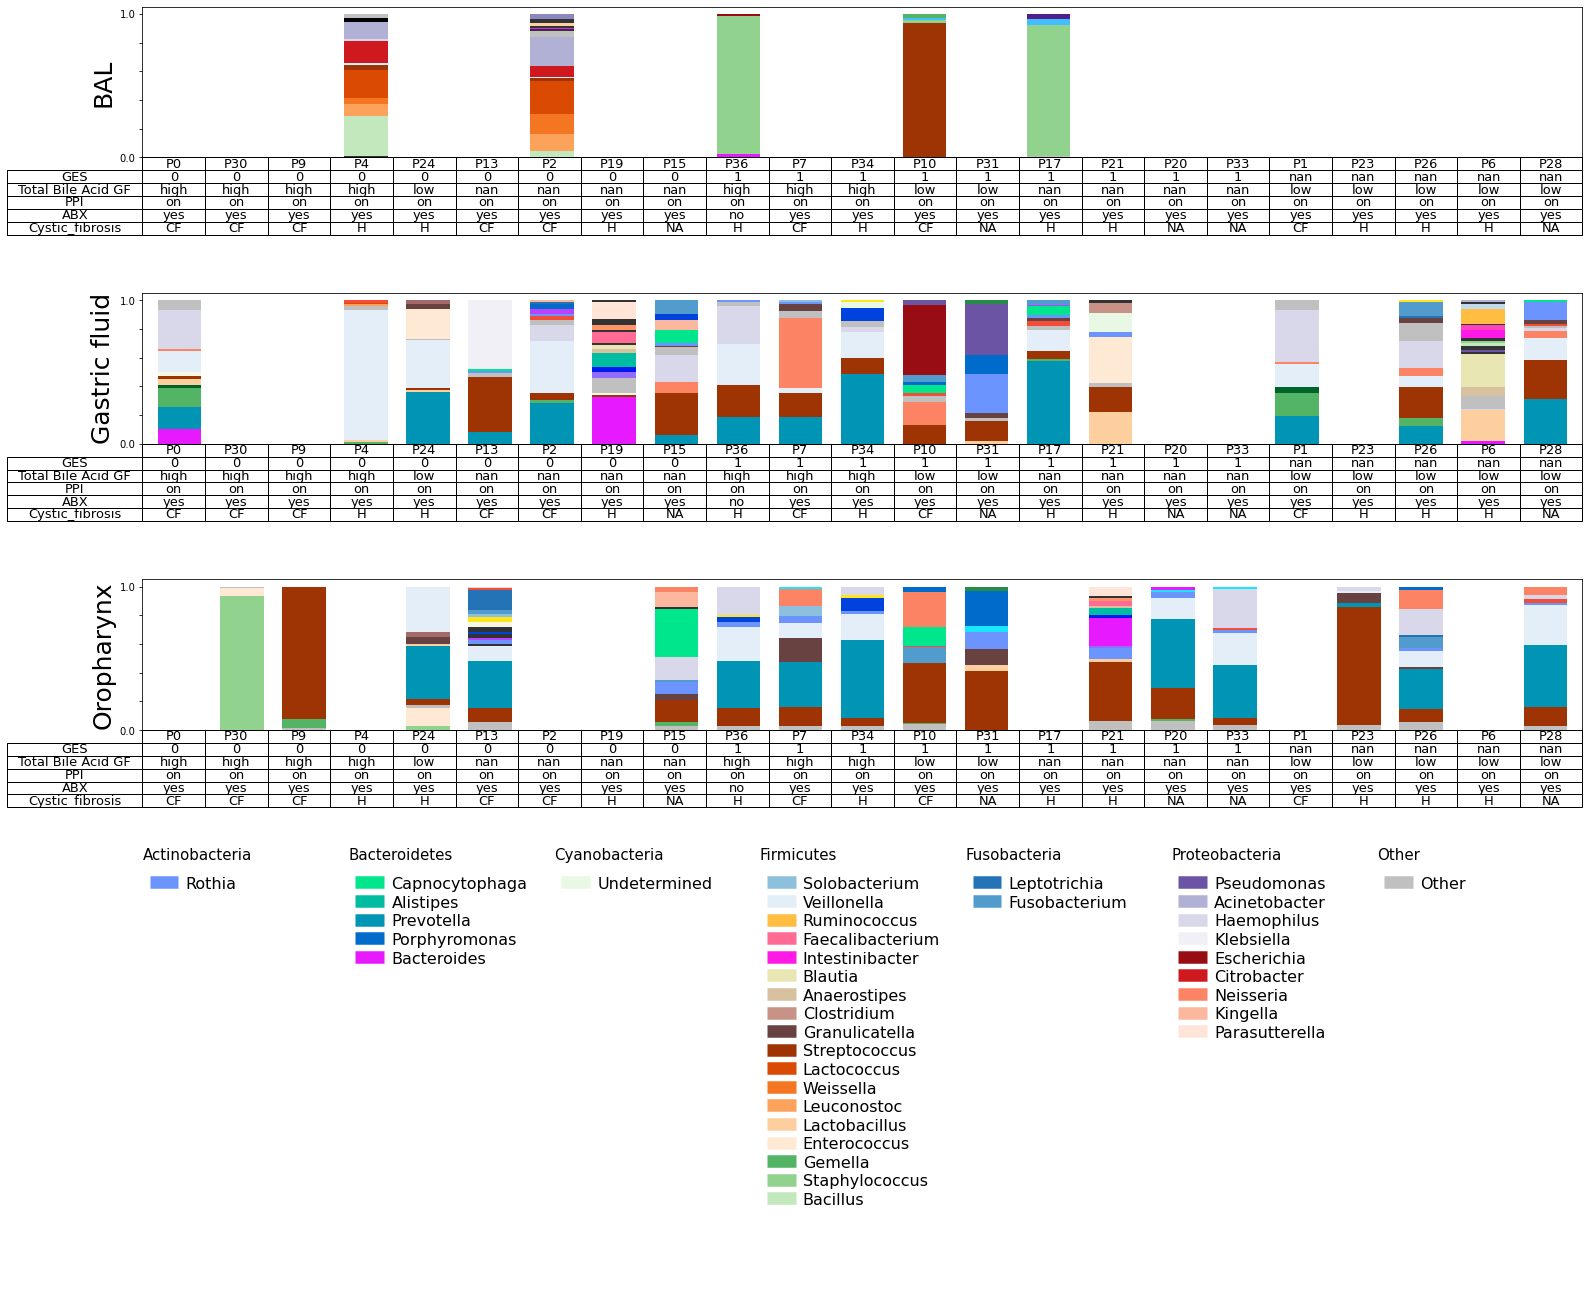

In [52]:
fig = plt.figure(figsize=(20,15))

ax1 = plt.subplot2grid((5, 7), (0, 0), colspan=7)
ax2 = plt.subplot2grid((5, 7), (1, 0), colspan=7)
ax3 = plt.subplot2grid((5, 7), (2, 0), colspan=7)
# axis for taxon + color text
ax4 = plt.subplot2grid((5, 7), (3, 0), rowspan=2)
ax5 = plt.subplot2grid((5, 7), (3, 1), rowspan=2)
ax6 = plt.subplot2grid((5, 7), (3, 2), rowspan=2)
ax7 = plt.subplot2grid((5, 7), (3, 3), rowspan=2)
ax8 = plt.subplot2grid((5, 7), (3, 4), rowspan=2)
ax9 = plt.subplot2grid((5, 7), (3, 5), rowspan=2)
ax10 = plt.subplot2grid((5, 7), (3, 6), rowspan=2)

width = 0.7
fontsize = 13
####### LUNG(0), STOMACH(1), THROAT(2) ###########

numbers = [0,1,2]
axes = [ax1, ax2, ax3]

number = 0
taxa_list_reduced = []

chosen_groups_to_plot = [0,1, 2]

for number in numbers:
    
    # To get the same color for the taxa each time when plotting 
    tax_list = []
    for x in range(len(list(taxa_BLAST_bar_plotting_ALL[chosen_groups_to_plot[number]].set_index('Plot name').loc[list(plot_dfs[number])].groupby(['Plot name', 'Full Taxa'], sort=False).sum().unstack().columns))):
        tax_list.append(list(taxa_BLAST_bar_plotting_ALL[chosen_groups_to_plot[number]].set_index('Plot name').loc[list(plot_dfs[number])].groupby(['Plot name', 'Full Taxa'], sort=False).sum().unstack().columns)[x][1])

    hh = taxa_BLAST_bar_plotting_ALL[chosen_groups_to_plot[number]].set_index('Plot name').loc[list(plot_dfs[number])].groupby(['Plot name', 'Full Taxa'], sort=False).sum().unstack().plot.bar(
        stacked=True, color=[test.get(x, '#333333') for x in tax_list], ax=axes[number], label=samID_list_str[number], width = width)

    # Add a table with GES and survival
    the_table = axes[number].table(cellText=plot_dfs[number].values,
              rowLabels=plot_dfs[number].index,
              colLabels=plot_dfs[number].columns,
              loc='bottom', cellLoc = 'center', rowLoc = 'center')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(fontsize)
        
    # To store which taxa are present in the plot
    for tax in tax_list:
        taxa_list_reduced.append(tax)


######### Taxa / color list ########
# Get the colors ina separate list
from matplotlib import colors as mcolors
import math

# Since there are so many taxa, only show the legend for taxa > number
taxa_color_dict_CFhealth_reduced = {}

for key, value in test.items():
    
    if key in list(set(CFhealth_taxas_reduced_legend['Full Taxa'])):

        taxa_color_dict_CFhealth_reduced[key] = value
        
    if not 'Other' in list(set(CFhealth_taxas_reduced_legend['Full Taxa'])):
        taxa_color_dict_CFhealth_reduced['Other'] = 'silver'

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in taxa_color_dict_CFhealth_reduced.items())
sorted_names = [name for hsv, name in by_hsv]

# Remove from sorted_names the taxa which are not plotted
sorted_names.sort(reverse=True)

############################ 
# Get the group names
group_names = list()
for item in sorted_names:
    
    # Phylum level
    tax_l = item.split('.')[0]
    group_names.append(tax_l)   

# Get unique group names
group_names_unique_tmp = list(set(group_names)) 

# Re-arrange order of elements in list, i.e put 'Other' as last element
if 'Other' in group_names_unique_tmp:
    group_names_unique_tmp.remove('Other')
    group_names_unique_tmp.sort()
    group_names_unique_tmp.append('Other')
try:
    group_names_unique_tmp.remove('Undetermined')
except ValueError:
    pass
    
group_names_unique = group_names_unique_tmp

ph_taxa_dict = {} # One dict with the full taxa name
ph_taxa_dict_truncated = {} # One dict with only the genus part

# Make a dict with phylum as key and a list with the belonging taxas
for full_taxa in sorted_names:
    ph = full_taxa.split('.')[0] #phyla
    ge = full_taxa.split('.')[-1] #genus
    
    if ph in ph_taxa_dict:
        if not ge in ph_taxa_dict_truncated[ph]:
            ph_taxa_dict[ph].append(full_taxa)
            ph_taxa_dict_truncated[ph].append(ge)
    else:
        ph_taxa_dict[ph] = [full_taxa]
        ph_taxa_dict_truncated[ph] = [ge]

###################################################

axis = [ax4, ax5, ax6, ax7, ax8, ax9, ax10]

for i, phylum in enumerate(group_names_unique):
        
    n = len(ph_taxa_dict_truncated[phylum]) # To get the correct order of phylum
    
    ncols = 1    
    nrows = math.ceil(n / ncols)
    
    # Get height and width
    X = 100
    Y = 2000
    h = 85
    w = 70
    
    for j, name in enumerate(ph_taxa_dict[phylum]):

        # Pick which taxon level to print
        if name != 'Other':
            if name.split('.')[-2] == 'spp':
                name_split = ' '.join([name.split('.')[-3], name.split('.')[-2]])
            elif name.split('.')[-1] == 'Undetermined':
                name_split = name.split('.')[-1]
            else:
                name_split = name.split('.')[-1]
        else:
            name_split = name

        row = j % nrows
        col = j // nrows
        y = Y - (row * h) - h

        xi_line = w * (col + 0.05)
        xf_line = w * (col + 0.25)
        xi_text = w * (col + 0.3)

        axis[i].text(xi_text, y, name_split, fontsize=16,
                horizontalalignment='left',
                verticalalignment='center')

        axis[i].hlines(y + h * 0.1, xi_line, xf_line,
                    color=taxa_color_dict_CFhealth_reduced[name], linewidth=12.5)

    axis[i].set_xlim(0, X)
    axis[i].set_ylim(0, Y)
    axis[i].set_axis_off()

    fig.subplots_adjust(left=0, right=1,
                    top=1.2, bottom=0,
                    hspace=0, wspace=0)
    
    if i == 6:
        axis[i].set_title('Other', loc = 'left', fontsize=15)
    else:
        axis[i].set_title(name.split('.')[0], loc = 'left', fontsize=15)


# Adjusting x and y axis labels on subplot 1 and 2
ax1.set_ylabel('BAL', fontsize = 25)
ax2.set_ylabel('Gastric fluid', fontsize = 25)
ax3.set_ylabel('Oropharynx', fontsize = 25)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax1.set_yticklabels([0.0,'','','','',1.0])
ax2.set_yticklabels([0.0,'','','','',1.0])
ax3.set_yticklabels([0.0,'','','','',1.0])
ax1.tick_params(axis='x', which= 'both', length=0)
ax2.tick_params(axis='x', which= 'both', length=0)
ax3.tick_params(axis='x', which= 'both', length=0)

ax1.legend().remove()
ax2.legend().remove()
ax3.legend().remove()

plt.subplots_adjust(hspace = 0.9)
plt.show()